In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import pytensor.tensor as pt

df = pd.read_csv('/content/drive/MyDrive/ABDA/matches.csv')

/tmp/ipython-input-766355962.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/ABDA/matches.csv')


In [ ]:

# 1. Create Team Indices
# We pool all unique teams from both home and away columns
all_teams = pd.unique(df[['home_team_id', 'away_team_id']].values.ravel())
team_map = {team: i for i, team in enumerate(all_teams)}
num_teams = len(all_teams)

# 2. Create Season Indices (Temporal Index)
# Map years (1888-2023) to 0-135
seasons = sorted(df['season'].unique())
season_map = {year: i for i, year in enumerate(seasons)}
num_seasons = len(seasons)

# 3. Map the dataframe
df['home_idx'] = df['home_team_id'].map(team_map).values.astype("int64")
df['away_idx'] = df['away_team_id'].map(team_map).values.astype("int64")
df['season_idx'] = df['season'].map(season_map).values.astype("int64")

df['home_idx'] = df['home_idx'].astype("int64")
df['away_idx'] = df['away_idx'].astype("int64")
df['season_idx'] = df['season_idx'].astype("int64")

# Target variable: Home Team Margin
y = df['home_team_score_margin'].values

In [ ]:
df['season'].unique()

array([1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898,
       1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
       1910, 1911, 1912, 1913, 1914, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023])

In [ ]:
pip install numpyro jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.1/384.1 kB 8.7 MB/s eta 0:00:00


In [ ]:
import os

# Tell JAX to treat the CPU as having 4 "devices" (or however many cores you have)
# We set it to 4 just to be safe (so you can run 2 or 4 chains)
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"

import pymc as pm
# ... rest of your imports

In [ ]:
import numpyro
import jax

# This is the direct command to tell NumPyro/JAX how many cores to use
numpyro.set_host_device_count(2)

# Verify it worked
print(f"JAX now sees {jax.local_device_count()} device(s)")

JAX now sees 2 device(s)


## RQ2

In [ ]:
# Ensure your target data is ready
home_goals_obs = df['home_team_score'].values.astype("int64")
away_goals_obs = df['away_team_score'].values.astype("int64")
# Reuse your existing indices (h_idx, a_idx, s_idx) from the previous step
home_idx = df['home_idx'].values.astype("int64")
away_idx = df['away_idx'].values.astype("int64")
season_idx = df['season_idx'].values.astype("int64")
with pm.Model() as model_rq2:
    # --- HYPER-PRIORS (Level 3) ---
    # We need separate spreads for Attack and Defense
    sigma_att = pm.Exponential("sigma_att", 1.0)
    sigma_def = pm.Exponential("sigma_def", 1.0)

    # These control the Home Advantage evolution and team specific offsets
    sigma_drift = pm.Exponential("sigma_drift", 1.0)
    sigma_delta = pm.Exponential("sigma_delta", 1.0)

    # Global Intercept (Baseline goal rate for an average game)
    intercept = pm.Normal("intercept", mu=0, sigma=0.5)

    # --- TEAM SKILLS (Level 2) ---
    # 1. Attack Skills (Non-Centered)
    # att_offset = pm.Normal("att_offset", mu=0, sigma=1, shape=num_teams)
    # atts = pm.Deterministic("atts", att_offset * sigma_att)

    att_offset = pm.Normal("att_offset", mu=0.0, sigma=1.0, shape=num_teams)
    atts_raw = att_offset * sigma_att
    # center to enforce identifiability
    atts = pm.Deterministic("atts", atts_raw - atts_raw.mean())

    # 2. Defense Skills (Non-Centered) - Remember: Higher = Weaker Defense
    # def_offset = pm.Normal("def_offset", mu=0, sigma=1, shape=num_teams)
    # defs = pm.Deterministic("defs", def_offset * sigma_def)

    def_offset = pm.Normal("def_offset", mu=0.0, sigma=1.0, shape=num_teams)
    defs_raw = def_offset * sigma_def
    defs = pm.Deterministic("defs", defs_raw - defs_raw.mean())

    # --- HOME ADVANTAGE COMPONENTS ---
    # 1. Temporal Trend (Manual Random Walk to fix int8 error)
    # h_init = pm.Normal("h_init", mu=0, sigma=1.0)
    # h_steps = pm.Normal("h_steps", mu=0, sigma=1.0, shape=num_seasons - 1)
    # ha_temporal = pm.Deterministic("ha_temporal",
    #                                h_init + pm.math.concatenate([[0], pm.math.cumsum(h_steps * sigma_drift)]))
    # ha_temporal = pm.GaussianRandomWalk("ha_temporal",
    #                                     sigma=sigma_drift,
    #                                     shape=num_seasons)

    ha_temporal = pm.GaussianRandomWalk(
        "ha_temporal",
        sigma=sigma_drift,
        init_dist=pm.Normal.dist(0, 1.0),  # <--- This fixes the warning
        shape=num_seasons
    )

    # 2. Team-Specific HA Offset (Random Slopes)
    # delta_offset = pm.Normal("delta_offset", mu=0, sigma=1, shape=num_teams)
    # ha_team_offset = pm.Deterministic("ha_team_offset", delta_offset * sigma_delta)

    # 1. Create the raw offsets (Non-Centered Parameterization for speed)
    delta_offset = pm.Normal("delta_offset", mu=0, sigma=1, shape=num_teams)
    delta_raw = pm.Deterministic("delta_raw", delta_offset * sigma_delta)

    # 2. Apply the sum-to-zero constraint (Centering)
    # This forces the mean of all team offsets to be 0
    ha_team_offset = pm.Deterministic("ha_team_offset", delta_raw - pm.math.mean(delta_raw))
    # --- LINEAR PREDICTORS (Level 1) ---
    # We calculate the Log-Rate (theta) for both sides

    # Home Rate = Intercept + (Time HA + Team HA) + Home Attack + Away Defense
    lambda_h = pm.math.exp(intercept +
                          ha_temporal[season_idx] +
                           ha_team_offset[home_idx]+
                          atts[home_idx] +
                          defs[away_idx])

    # Away Rate = Intercept + Away Attack + Home Defense (No HA terms)
    lambda_a = pm.math.exp(intercept +
                          atts[away_idx] +
                          defs[home_idx])

    # --- LIKELIHOOD ---
    # We treat Home and Away goals as two separate Poisson observations
    # connected by the shared parameters above
    home_points = pm.Poisson("home_points", mu=lambda_h, observed=home_goals_obs)
    away_points = pm.Poisson("away_points", mu=lambda_a, observed=away_goals_obs)

    # --- SAMPLING ---
    # trace_rq2 = pm.sample(
    # draws=2000,
    # tune=2000,
    # chains=3,
    # target_accept=0.95,
    # return_inferencedata=True,
    #     idata_kwargs={"log_likelihood": True},
    # nuts_sampler="numpyro")

    # ppc = pm.sample_posterior_predictive(trace_rq2)


In [ ]:
import numpy as np

# 1. Get the predicted means (posterior predictive)
# (If you haven't run sample_posterior_predictive, do that first)
ppc = pm.sample_posterior_predictive(trace_rq2, model=model_rq2)

# 2. Calculate RMSE for Home Goals
home_pred = ppc.posterior_predictive["home_points"].mean(dim=["chain", "draw"])
rmse_home = np.sqrt(np.mean((home_goals_obs - home_pred)**2))

print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

Output()

In [1]:
import matplotlib.pyplot as plt

# Ensure obs_h is defined (assuming df is available from previous cells)
obs_h = df['home_team_score'].values.astype("int64")

# Calculate residuals
residuals = obs_h - home_pred

# Create the residual plot
plt.figure(figsize=(10, 6))
plt.scatter(home_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', label='Zero Residuals')
plt.title('Residual Plot: Observed Home Goals vs. Predicted Home Goals')
plt.xlabel('Predicted Home Goals')
plt.ylabel('Residuals (Observed - Predicted)')
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'obs_h' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, stat='density', color='skyblue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals (Observed - Predicted)')
plt.ylabel('Density')
plt.axvline(0, color='red', linestyle='--', label='Zero Residuals')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
az.to_netcdf(
    trace_rq2,
    "/content/drive/MyDrive/ABDA/trace_rq2_11feb2026.nc"
)

In [ ]:
import arviz as az

trace_rq2 = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_rq23.nc")

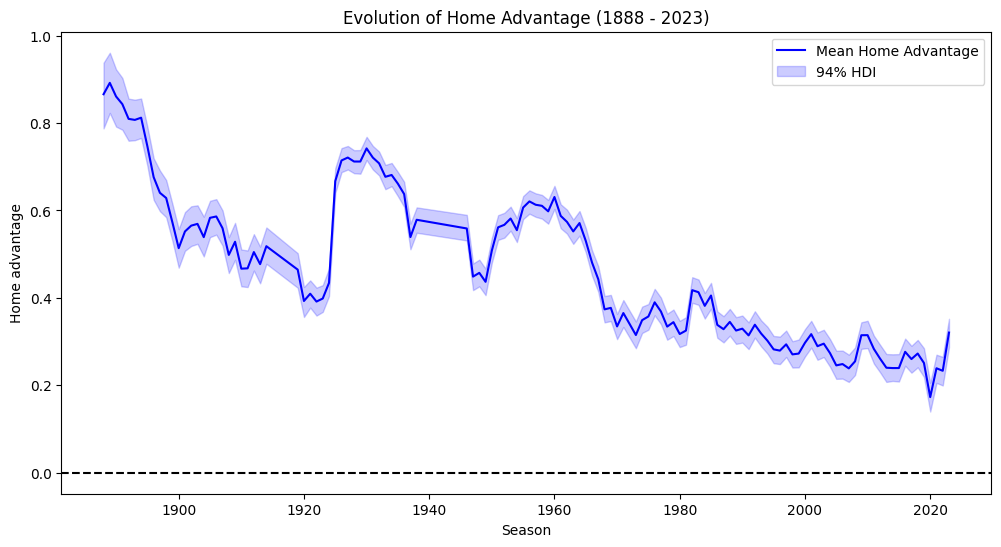

In [ ]:

import matplotlib.pyplot as plt

# Extract the posterior mean for the temporal effect
post_ha = trace_rq2.posterior["ha_temporal"].mean(dim=["chain", "draw"])
hdi_ha = az.hdi(trace_rq2).ha_temporal # Highest Density Interval (Uncertainty)

plt.figure(figsize=(12, 6))
plt.plot(seasons, post_ha, label="Mean Home Advantage", color="blue")
plt.fill_between(seasons, hdi_ha[:, 0], hdi_ha[:, 1], color="blue", alpha=0.2, label="94% HDI")

plt.axhline(0, color="black", linestyle="--")
plt.title("Evolution of Home Advantage (1888 - 2023)")
plt.xlabel("Season")
plt.ylabel("Home advantage")
plt.legend()
plt.show()

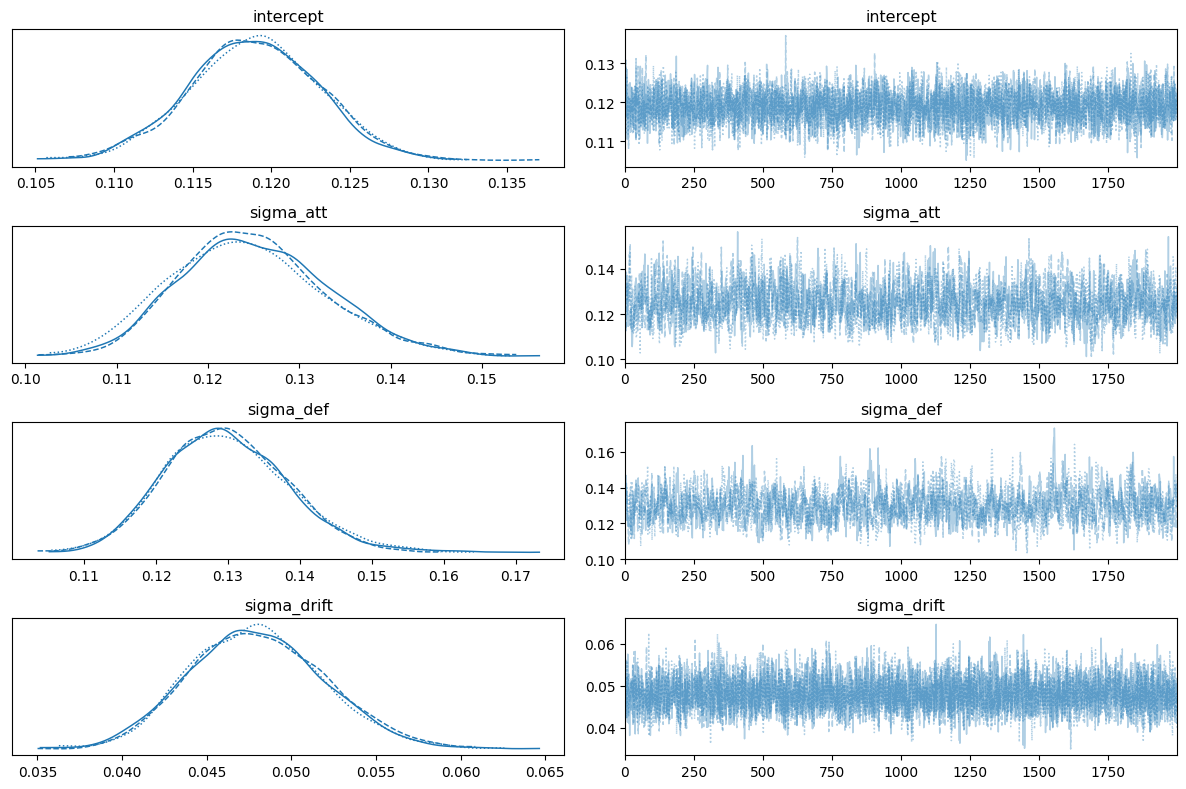

In [ ]:
# Usually, we plot just the hyper-priors first so the screen isn't crowded
az.plot_trace(trace_rq2, var_names=["intercept","sigma_att", "sigma_def","sigma_drift"])

# az.plot_forest(trace_rq2, var_names=["att"], combined=True, coords={"att_dim_0": range(10)})
plt.tight_layout()

In [ ]:
summary = az.summary(trace_rq2, var_names=["intercept","sigma_att", "sigma_def","sigma_drift"])
print(summary)

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept    0.119  0.004   0.111    0.126        0.0      0.0    3917.0   
sigma_att    0.125  0.008   0.109    0.140        0.0      0.0    1313.0   
sigma_def    0.130  0.009   0.114    0.146        0.0      0.0     820.0   
sigma_drift  0.048  0.004   0.041    0.056        0.0      0.0    6580.0   

             ess_tail  r_hat  
intercept      4937.0    1.0  
sigma_att      2198.0    1.0  
sigma_def      1540.0    1.0  
sigma_drift    5063.0    1.0  


## Summary of RQ3 Analysis:

### Data Analysis Key Findings for RQ3
*   **Global Attack Trend (`att_t`):** The evolution of the global attack trend over seasons (1888-2023) was plotted, showing its posterior mean and 94% HDI. This visualization indicates how the overall attacking strength in the league has changed across different eras.
*   **Global Defense Trend (`def_t`):** Similarly, the evolution of the global defense trend over seasons was plotted, revealing changes in the league's overall defensive strength over time.
*   **Team-Specific Attack (`alpha[0]`):** The trace plot for `alpha[0]` (the attack parameter for the first team) was generated, illustrating its posterior distribution and MCMC samples, which is crucial for assessing convergence and the parameter's uncertainty.
*   **Parameter Distinction:** It was clarified that `alpha` represents team-specific attack offsets (indexed by team), while `att_t` represents the global attack trend (indexed by season).

### Insights or Next Steps
*   **Trend Interpretation:** Analyzing the `att_t` and `def_t` plots can provide insights into historical periods where the game was more attack-oriented versus defense-oriented, or periods of significant rule changes impacting scoring.
*   **Team Performance:** Further investigation of individual team `alpha` and `delta` parameters (attack and defense offsets) could reveal long-term team strengths and weaknesses.
*   **Model Diagnostics:** For robust conclusions, it's recommended to thoroughly examine the trace plots, R-hat values, and effective sample sizes for all parameters to ensure model convergence and reliable inference.

In [ ]:
import arviz as az

# Focus on the 'global' parameters first
summary_global = az.summary(trace_rq2, var_names=["intercept", "sigma_att", "sigma_def", "sigma_drift"])
display(summary_global)

In [ ]:
import numpy as np

# 1. Get the predicted means (posterior predictive)
# (If you haven't run sample_posterior_predictive, do that first)
# ppc = pm.sample_posterior_predictive(trace_rq2, model=model_rq2)

# 2. Calculate RMSE for Home Goals
home_pred = ppc.posterior_predictive["home_points"].mean(dim=["chain", "draw"])
rmse_home = np.sqrt(np.mean((home_goals_obs - home_pred)**2))

print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

In [ ]:
summary = az.summary(trace_rq2, var_names=["sigma_att", "sigma_def","atts", "defs"])
print(summary)

In [ ]:
summary = az.summary(trace, var_names=["u"])
print(summary)

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
u[0]   -0.277  0.148  -0.552    0.008      0.004    0.004    1231.0    1202.0   
u[1]    0.596  0.048   0.507    0.686      0.005    0.002     111.0     390.0   
u[2]    0.397  0.049   0.308    0.490      0.005    0.002     115.0     390.0   
u[3]    0.364  0.048   0.274    0.453      0.004    0.002     119.0     354.0   
u[4]    0.284  0.049   0.198    0.378      0.005    0.001     114.0     454.0   
...       ...    ...     ...      ...        ...      ...       ...       ...   
u[139]  0.047  0.086  -0.107    0.212      0.005    0.002     305.0     863.0   
u[140] -0.189  0.108  -0.398    0.001      0.004    0.003     582.0    1253.0   
u[141]  0.072  0.123  -0.163    0.293      0.003    0.003    1345.0    1291.0   
u[142] -0.260  0.133  -0.514   -0.014      0.003    0.003    1592.0    1132.0   
u[143] -0.234  0.145  -0.498    0.026      0.003    0.003    2008.0    1613.0   

        r_hat  
u[0]     1.

In [ ]:
summary = az.summary(trace, var_names=["ha_temporal"])
print(summary)

                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ha_temporal[0]    1.173  0.073   1.041    1.316      0.002    0.001    1618.0   
ha_temporal[1]    1.196  0.065   1.081    1.323      0.002    0.001    1492.0   
ha_temporal[2]    1.204  0.059   1.095    1.311      0.002    0.001    1416.0   
ha_temporal[3]    1.209  0.053   1.102    1.305      0.001    0.001    1311.0   
ha_temporal[4]    1.202  0.048   1.110    1.290      0.001    0.001    1441.0   
...                 ...    ...     ...      ...        ...      ...       ...   
ha_temporal[120]  0.263  0.028   0.210    0.315      0.001    0.001    2143.0   
ha_temporal[121]  0.208  0.029   0.150    0.259      0.001    0.001    1966.0   
ha_temporal[122]  0.255  0.028   0.201    0.305      0.001    0.001    2429.0   
ha_temporal[123]  0.269  0.028   0.218    0.320      0.001    0.001    2022.0   
ha_temporal[124]  0.278  0.031   0.215    0.332      0.001    0.001    2399.0   

                  ess_tail 

In [ ]:
summary = az.summary(trace, var_names=["ha_team_offset"])
print(summary)

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
ha_team_offset[0]   -0.024  0.069  -0.158    0.100      0.001    0.002   
ha_team_offset[1]   -0.027  0.041  -0.098    0.052      0.001    0.001   
ha_team_offset[2]    0.002  0.041  -0.075    0.077      0.001    0.001   
ha_team_offset[3]   -0.014  0.041  -0.093    0.064      0.001    0.001   
ha_team_offset[4]    0.013  0.042  -0.065    0.097      0.001    0.001   
...                    ...    ...     ...      ...        ...      ...   
ha_team_offset[139] -0.032  0.062  -0.155    0.076      0.001    0.001   
ha_team_offset[140] -0.060  0.068  -0.187    0.065      0.001    0.002   
ha_team_offset[141] -0.034  0.067  -0.153    0.093      0.001    0.002   
ha_team_offset[142] -0.029  0.066  -0.159    0.089      0.001    0.002   
ha_team_offset[143]  0.018  0.069  -0.114    0.147      0.001    0.002   

                     ess_bulk  ess_tail  r_hat  
ha_team_offset[0]      3126.0    1257.0    1.0  
ha_team_offse

array([[<Axes: title={'center': 'sigma_u'}>,
        <Axes: title={'center': 'sigma_u'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>]],
      dtype=object)

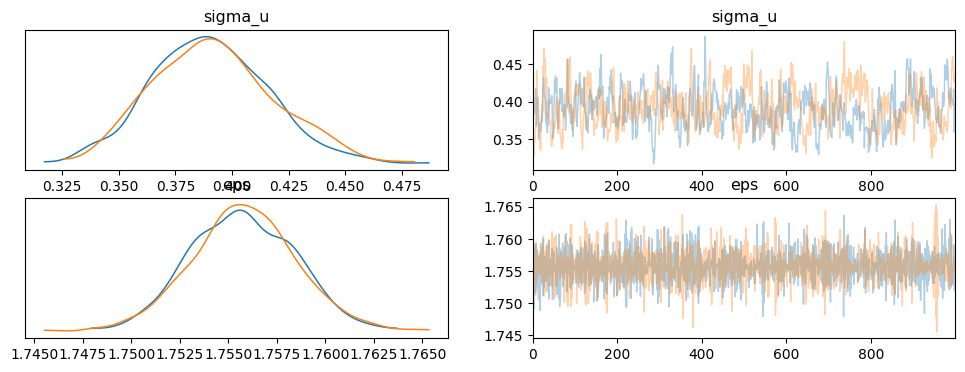

In [ ]:
az.plot_trace(trace, var_names=["sigma_u", "eps"], compact=False)

# Task
Calculate the variance of the 'atts' and 'defs' parameters from the `trace_rq2` object to determine `Vlatent`. Then, calculate `Vhome` from the 'ha_temporal' parameter by taking its mean, squaring it, and multiplying by 0.25. Finally, compute and display the ratio `Vhome / (Vhome + Vlatent)`.

## Calculate Latent Strength Variance (Vlatent)

### Subtask:
Extract the 'atts' and 'defs' parameters from the `trace_rq2` object, calculate their variances, and sum them to get `Vlatent`.


**Reasoning**:
First, extract the 'atts' parameter from the `trace_rq2` object and calculate its variance. Then extract the 'defs' parameter and calculate its variance. Finally, sum the two variances to get `Vlatent`.



In [ ]:
atts_samples = trace_rq2.posterior['atts'].values.flatten()
var_atts = np.var(atts_samples)

defs_samples = trace_rq2.posterior['defs'].values.flatten()
var_defs = np.var(defs_samples)

Vlatent = var_atts + var_defs

print(f"Variance of atts: {var_atts:.4f}")
print(f"Variance of defs: {var_defs:.4f}")
print(f"Vlatent (Sum of variances): {Vlatent:.4f}")

Variance of atts: 0.0153
Variance of defs: 0.0164
Vlatent (Sum of variances): 0.0317


**Reasoning**:
Now that `Vlatent` has been calculated, the next step is to calculate `Vhome`. This involves extracting the 'ha_temporal' parameter, computing its mean, squaring the mean, and then multiplying by 0.25, as per the main task description.



In [ ]:
ha_temporal_samples = trace_rq2.posterior['ha_temporal'].values.flatten()
var_ha_temporal = np.var(ha_temporal_samples)

ha_team_offset_samples = trace_rq2.posterior['ha_team_offset'].values.flatten()
var_ha_team_offset = np.var(ha_team_offset_samples)
Vhome = var_ha_temporal + var_ha_team_offset
print(f"Variance of ha_temporal: {var_ha_temporal:.4f}")
print(f"Variance of ha_team_offset: {var_ha_team_offset:.4f}")

Variance of ha_temporal: 0.0302
Variance of ha_team_offset: 0.0016


In [ ]:
ha_temporal_samples = trace_rq2.posterior['ha_temporal'].values.flatten()
mean_ha_temporal = np.mean(ha_temporal_samples)
Vhome = (mean_ha_temporal**2) * 0.25

print(f"Mean of ha_temporal: {mean_ha_temporal:.4f}")
print(f"Vhome: {Vhome:.4f}")

Mean of ha_temporal: 0.4670
Vhome: 0.0545


**Reasoning**:
With `Vlatent` and `Vhome` both calculated, the final step is to compute their ratio `Vhome / (Vhome + Vlatent)` as specified in the main task and display the result.



In [ ]:
ratio = Vhome / (Vhome + Vlatent)
print(f"Ratio Vhome / (Vhome + Vlatent): {ratio:.4f}")

Ratio Vhome / (Vhome + Vlatent): 0.5013


# RQ3

In [ ]:
idx_s = df['season_idx'].values.astype("int64")
idx_h = df['home_idx'].values.astype("int64")
idx_a = df['away_idx'].values.astype("int64")
obs_h = df['home_team_score'].values.astype("int64")
obs_a = df['away_team_score'].values.astype("int64")

with pm.Model() as model_rq3_final:

    # --- Intercept: baseline scoring rate ---
    mu = pm.Normal("mu", 0.0, 0.5)

    # --- Net scoring trend: captures era-level changes ---
    # NOTE: This is the ONLY thing the data can identify globally.
    # A positive trend means scoring increased — we cannot attribute
    # this to attack or defense in isolation without external assumptions.
    sigma_net = pm.Exponential("sigma_net", lam=2.0)
    sigma_ha  = pm.Exponential("sigma_ha",  lam=2.0)

    z_net = pm.Normal("z_net", 0.0, 1.0, shape=num_seasons)
    z_ha  = pm.Normal("z_ha",  0.0, 1.0, shape=num_seasons)

    net_curve = pm.Deterministic("net_curve", pt.cumsum(sigma_net * z_net))
    ha_curve  = pm.Deterministic("ha_curve",  pt.cumsum(sigma_ha  * z_ha))

    # --- Team offsets: these ARE separately identified ---
    # Because team A's attack faces team B's defense (not its own),
    # cross-game variation identifies alpha and delta separately.
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1.0)
    sigma_delta = pm.Exponential("sigma_delta", lam=1.0)

    alpha_raw = pm.Normal("alpha_raw", 0.0, sigma=sigma_alpha, shape=num_teams)
    delta_raw = pm.Normal("delta_raw", 0.0, sigma=sigma_delta, shape=num_teams)
    alpha = pm.Deterministic("alpha", alpha_raw - alpha_raw.mean())
    delta = pm.Deterministic("delta", delta_raw - delta_raw.mean())

    # --- Predictors ---
    log_mu_h = mu + ha_curve[idx_s] + net_curve[idx_s] + alpha[idx_h] - delta[idx_a]
    log_mu_a = mu +                   net_curve[idx_s] + alpha[idx_a] - delta[idx_h]

    home_goals = pm.Poisson("home_goals", mu=pm.math.exp(log_mu_h), observed=obs_h)
    away_goals = pm.Poisson("away_goals", mu=pm.math.exp(log_mu_a), observed=obs_a)

    # trace_rq3 = pm.sample(1000, tune=1000, chains=2,
    #                       return_inferencedata=True,
    #     idata_kwargs={"log_likelihood": True},
    #                       target_accept=0.9, nuts_sampler="numpyro", random_seed=42)

In [ ]:
az.to_netcdf(
    trace_rq2,
    "/content/drive/MyDrive/ABDA/trace_rq2_12feb2026.nc"
)

'/content/drive/MyDrive/ABDA/trace_rq3_12feb2026.nc'

In [ ]:
import arviz as az

trace_rq2 = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_rq2_12feb2026.nc")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
# 1. Get the predicted means (posterior predictive)
# (If you haven't run sample_posterior_predictive, do that first)
ppc = pm.sample_posterior_predictive(trace_rq3, model=model_rq3_final)

# 2. Calculate RMSE for Home Goals
home_pred = ppc.posterior_predictive["home_goals"].mean(dim=["chain", "draw"])
rmse_home = np.sqrt(np.mean((obs_h - home_pred)**2))

print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

Output()

Average error in home goals: 1.384


In [ ]:
print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

NameError: name 'rmse_home' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
# 1. Get the predicted means (posterior predictive)
# (If you haven't run sample_posterior_predictive, do that first)
ppc = pm.sample_posterior_predictive(trace_rq3, model=model_rq3_final)

# 2. Calculate RMSE for Home Goals
home_pred = ppc.posterior_predictive["away_goals"].mean(dim=["chain", "draw"])
rmse_home = np.sqrt(np.mean((obs_a - home_pred)**2))

print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

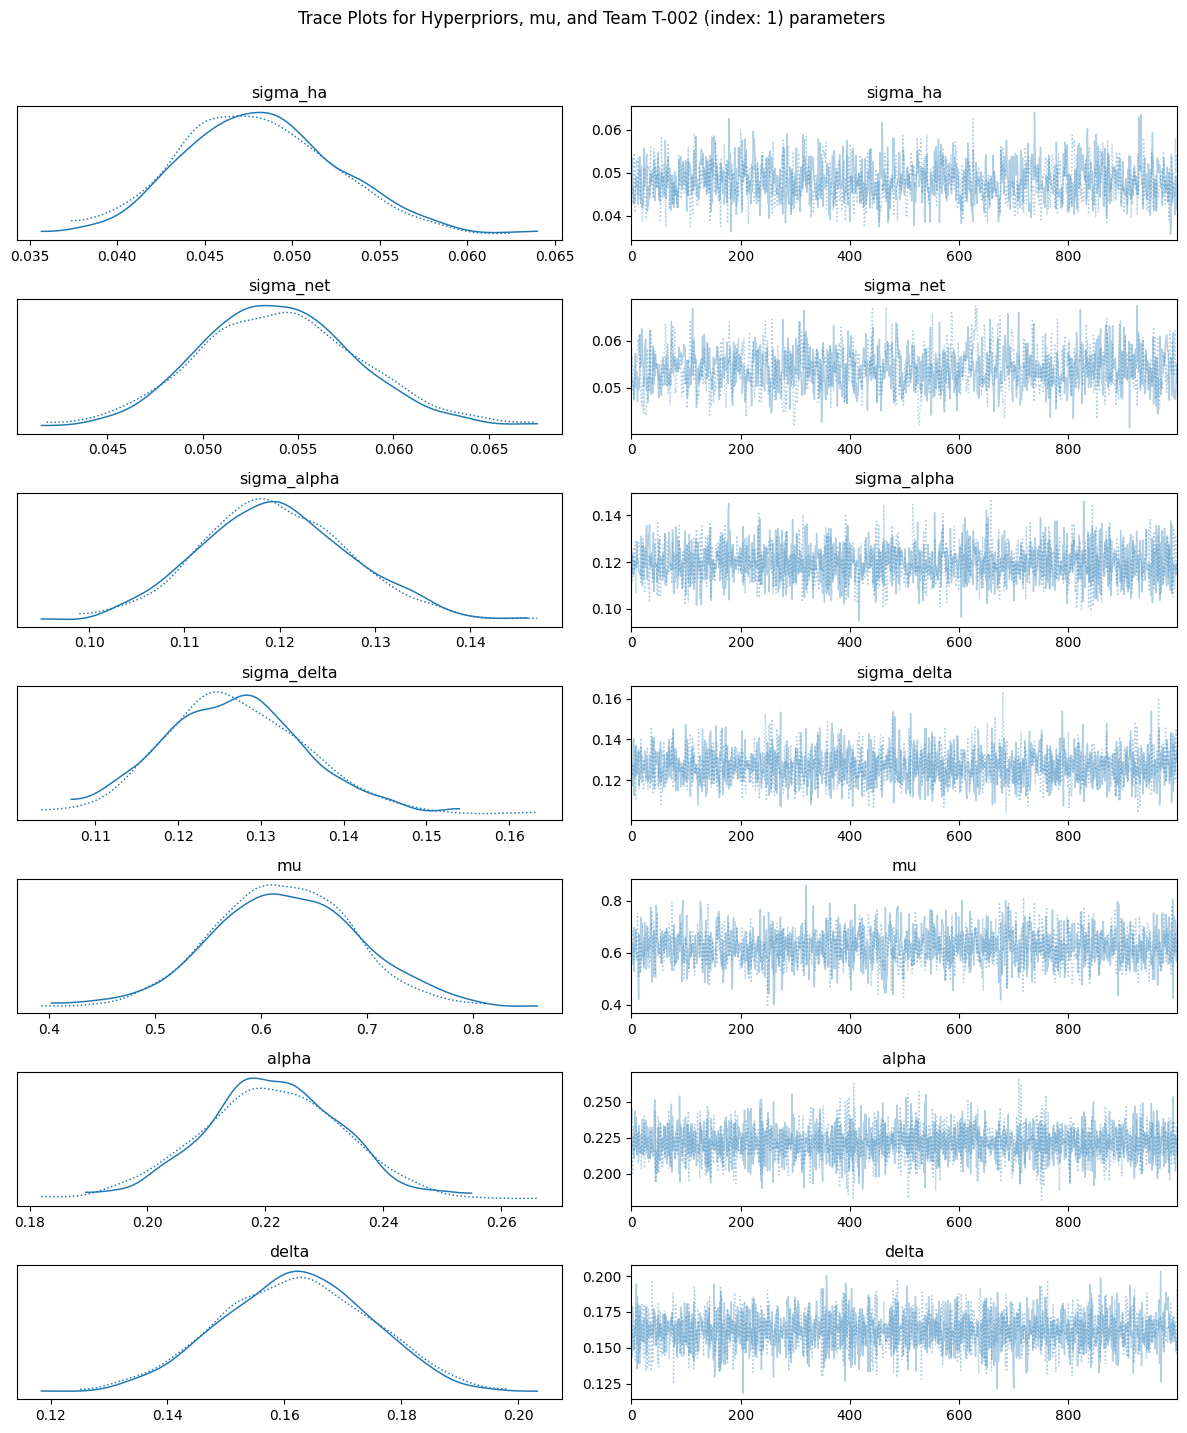

In [ ]:
# Usually, we plot just the hyper-priors first so the screen isn't crowded
import matplotlib.pyplot as plt
import arviz as az

# Define the selected team's ID and get its index for plotting
selected_team_id = 'T-002' # Aston Villa
selected_team_index = team_map.get(selected_team_id)

if selected_team_index is not None:
    az.plot_trace(trace_rq3,
                  var_names=["sigma_ha", "sigma_net", "sigma_alpha", "sigma_delta", "mu", "alpha", "delta"],
                  coords={
                      "alpha_dim_0": [selected_team_index],
                      "delta_dim_0": [selected_team_index]
                  })
    plt.suptitle(f"Trace Plots for Hyperpriors, mu, and Team {selected_team_id} (index: {selected_team_index}) parameters", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print(f"Team ID '{selected_team_id}' not found in team_map.")

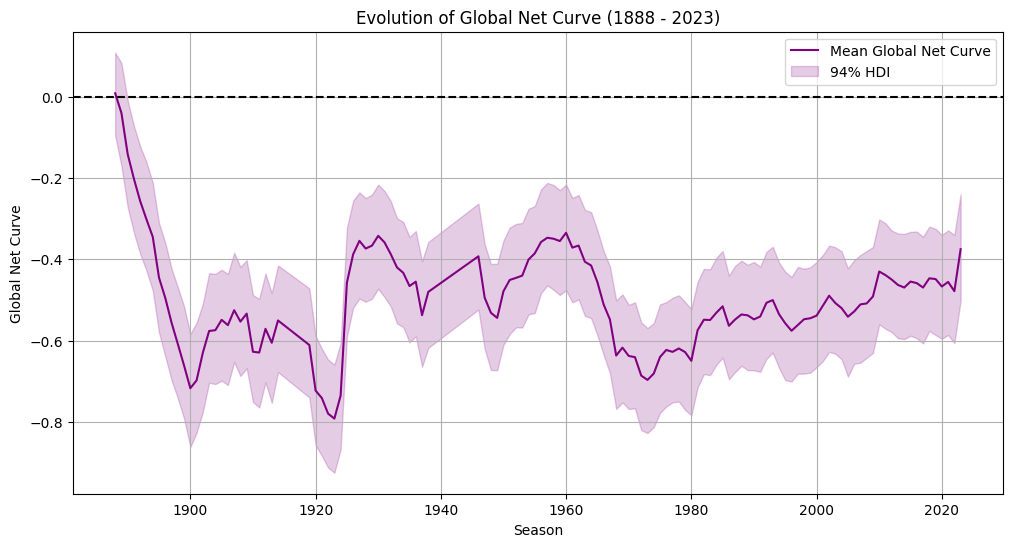

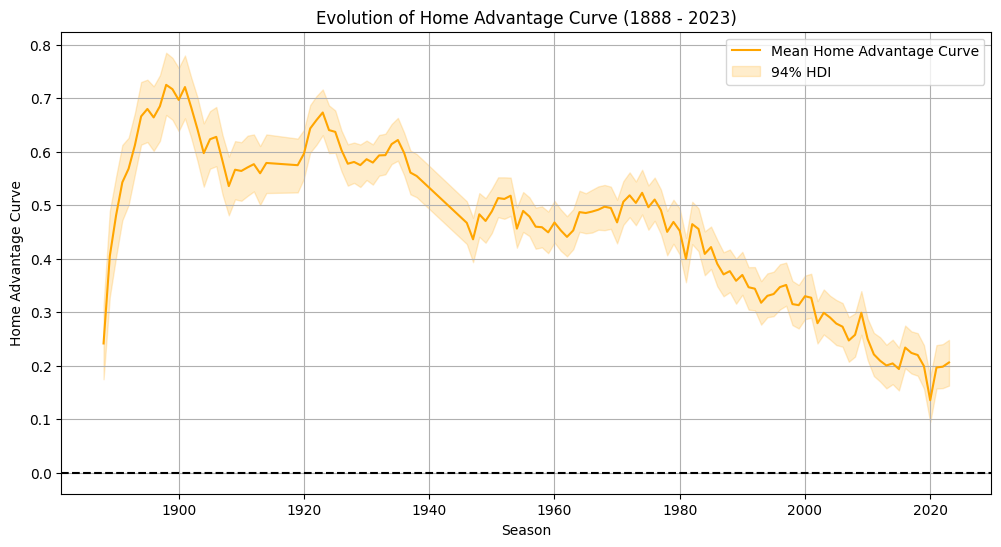

In [ ]:
import matplotlib.pyplot as plt
import arviz as az

# Extract the posterior mean for the net curve
post_net_curve = trace_rq3.posterior["net_curve"].mean(dim=["chain", "draw"])
hdi_net_curve = az.hdi(trace_rq3, var_names=["net_curve"])['net_curve']

plt.figure(figsize=(12, 6))
plt.plot(seasons, post_net_curve, label="Mean Global Net Curve", color="purple")
plt.fill_between(seasons, hdi_net_curve[:, 0], hdi_net_curve[:, 1], color="purple", alpha=0.2, label="94% HDI")

plt.axhline(0, color="black", linestyle="--")
plt.title("Evolution of Global Net Curve (1888 - 2023)")
plt.xlabel("Season")
plt.ylabel("Global Net Curve")
plt.legend()
plt.grid(True)
plt.show()

# Extract the posterior mean for the home advantage curve
post_ha_curve = trace_rq3.posterior["ha_curve"].mean(dim=["chain", "draw"])
hdi_ha_curve = az.hdi(trace_rq3, var_names=["ha_curve"])['ha_curve']

plt.figure(figsize=(12, 6))
plt.plot(seasons, post_ha_curve, label="Mean Home Advantage Curve", color="orange")
plt.fill_between(seasons, hdi_ha_curve[:, 0], hdi_ha_curve[:, 1], color="orange", alpha=0.2, label="94% HDI")

plt.axhline(0, color="black", linestyle="--")
plt.title("Evolution of Home Advantage Curve (1888 - 2023)")
plt.xlabel("Season")
plt.ylabel("Home Advantage Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

# Variance of ha_curve (Home Advantage Trend)
ha_curve_samples = trace_rq3.posterior['ha_curve'].values.flatten()
var_ha_curve = np.var(ha_curve_samples)
print(f"Variance of ha_curve (Home Advantage Trend): {var_ha_curve:.4f}")

# Variance of net_curve (Global Scoring Trend)
net_curve_samples = trace_rq3.posterior['net_curve'].values.flatten()
var_net_curve = np.var(net_curve_samples)
print(f"Variance of net_curve (Global Scoring Trend): {var_net_curve:.4f}")

# Variance of alpha (Team-specific Attack Offsets)
alpha_samples = trace_rq3.posterior['alpha'].values.flatten()
var_alpha = np.var(alpha_samples)
print(f"Variance of alpha (Team-specific Attack Offsets): {var_alpha:.4f}")

# Variance of delta (Team-specific Defense Offsets)
delta_samples = trace_rq3.posterior['delta'].values.flatten()
var_delta = np.var(delta_samples)
print(f"Variance of delta (Team-specific Defense Offsets): {var_delta:.4f}")

Variance of ha_curve (Home Advantage Trend): 0.0218
Variance of net_curve (Global Scoring Trend): 0.0216
Variance of alpha (Team-specific Attack Offsets): 0.0140
Variance of delta (Team-specific Defense Offsets): 0.0157


In [ ]:
print(var_ha_curve/(var_ha_curve+var_net_curve+var_alpha+var_delta))

0.29784546621252206


In [ ]:
print(var_net_curve+var_alpha+var_delta)

0.05138205527063203


In [ ]:
import arviz as az

# Get the index for team 'T-002'
selected_team_id = 'T-002'
selected_team_index = team_map.get(selected_team_id)

if selected_team_index is not None:
    # 1. Summary for all hyperpriors
    print("\nSummary Statistics for all Hyperpriors:")
    summary_hyperpriors = az.summary(
        trace_rq3,
        var_names=[
            "mu",
            "sigma_alpha",
            "sigma_delta",
            "sigma_ha",
            "sigma_net",
        ]
    )
    display(summary_hyperpriors)

    # 2. Summary for alpha and delta of the selected team
    print(f"\nSummary Statistics for Alpha and Delta of Team {selected_team_id} (index: {selected_team_index}):")
    summary_team_specific = az.summary(
        trace_rq3,
        var_names=["alpha", "delta"],
        coords={"alpha_dim_0": [selected_team_index], "delta_dim_0": [selected_team_index]}
    )
    display(summary_team_specific)

    # 3. Summary for ha_curve and net_curve for a particular season (e.g., 1966)
    selected_year = 1966
    year_idx = seasons.index(selected_year)
    print(f"\nSummary Statistics for ha_curve and net_curve in season {selected_year} (index: {year_idx}):")
    summary_curves_for_season = az.summary(
        trace_rq3,
        var_names=["ha_curve", "net_curve"],
        coords={
            "ha_curve_dim_0": [year_idx],
            "net_curve_dim_0": [year_idx]
        }
    )
    display(summary_curves_for_season)

else:
    print(f"Team ID '{selected_team_id}' not found in team_map.")


Summary Statistics for all Hyperpriors:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.622,0.067,0.495,0.750,0.002,0.001,1850.0,1340.0,1.0
sigma_alpha,0.120,0.008,0.106,0.136,0.000,0.000,2402.0,1648.0,1.0
sigma_delta,0.127,0.008,0.112,0.143,0.000,0.000,2401.0,1436.0,1.0
sigma_ha,0.048,0.004,0.040,0.056,0.000,0.000,1024.0,1381.0,1.0
sigma_net,0.054,0.004,0.046,0.062,0.000,0.000,815.0,956.0,1.0



Summary Statistics for Alpha and Delta of Team T-002 (index: 1):


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[1],0.221,0.012,0.199,0.244,0.0,0.0,4240.0,1363.0,1.0
delta[1],0.162,0.013,0.138,0.186,0.0,0.0,3508.0,1381.0,1.0



Summary Statistics for ha_curve and net_curve in season 1966 (index: 67):


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ha_curve[67],0.488,0.021,0.449,0.529,0.000,0.000,2013.0,1594.0,1.0
net_curve[67],-0.512,0.069,-0.636,-0.380,0.002,0.002,1880.0,1365.0,1.0


team aston villa, year 1966

Plotting trace for net_curve and ha_curve for season 1966 (index: 67)


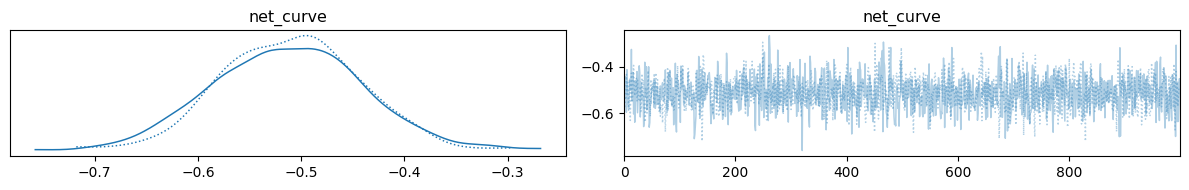

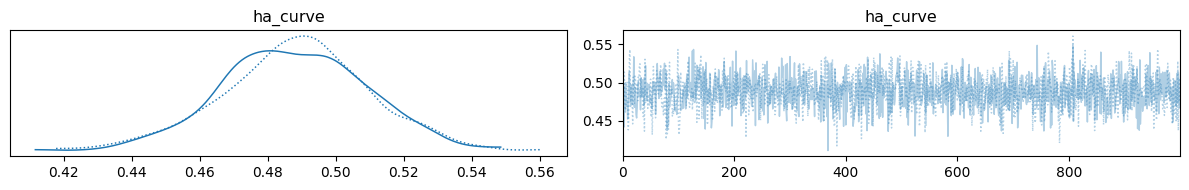

In [ ]:
# Get the index for the year 1966
year_to_plot = 1966
year_idx = seasons.index(year_to_plot)

print(f"Plotting trace for net_curve and ha_curve for season {year_to_plot} (index: {year_idx})")

# Plot trace for net_curve for the selected season
az.plot_trace(trace_rq3, var_names=["net_curve"], coords={"net_curve_dim_0": [year_idx]})
# plt.suptitle(f"Trace Plot for Global Net Curve in Season {year_to_plot}", y=1.02)
plt.tight_layout()
plt.show()

# Plot trace for ha_curve for the selected season
az.plot_trace(trace_rq3, var_names=["ha_curve"], coords={"ha_curve_dim_0": [year_idx]})
# plt.suptitle(f"Trace Plot for Home Advantage Curve in Season {year_to_plot}", y=1.02)
plt.tight_layout()
plt.show()

Plotting trace for team: T-002 (index: 1)


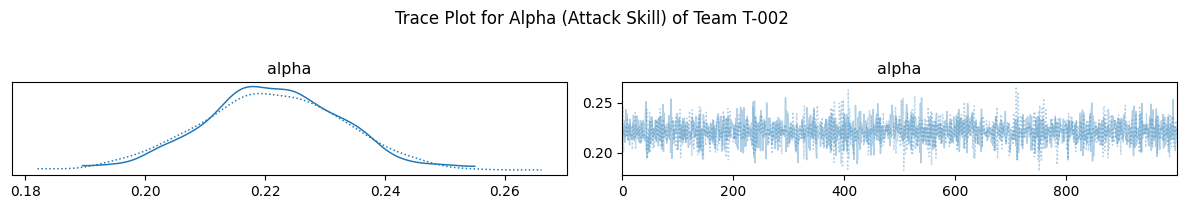

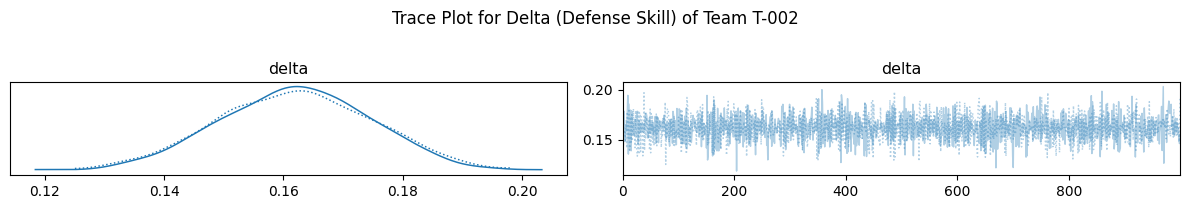

In [ ]:
import matplotlib.pyplot as plt
import arviz as az

# Select a specific team (e.g., Aston Villa, which is 'T-002')
selected_team_id = 'T-002'
selected_team_index = team_map.get(selected_team_id)

if selected_team_index is not None:
    print(f"Plotting trace for team: {selected_team_id} (index: {selected_team_index})")

    # Plot trace for alpha of the selected team
    az.plot_trace(trace_rq3, var_names=["alpha"], coords={"alpha_dim_0": [selected_team_index]})
    plt.suptitle(f"Trace Plot for Alpha (Attack Skill) of Team {selected_team_id}", y=1.02) # Adjust suptitle position
    plt.tight_layout()
    plt.show()

    # Plot trace for delta of the selected team
    az.plot_trace(trace_rq3, var_names=["delta"], coords={"delta_dim_0": [selected_team_index]})
    plt.suptitle(f"Trace Plot for Delta (Defense Skill) of Team {selected_team_id}", y=1.02) # Adjust suptitle position
    plt.tight_layout()
    plt.show()
else:
    print(f"Team ID '{selected_team_id}' not found in team_map.")